In [44]:
!pip install -q kaggle
!pip install -q opencv-python
!pip install -q pydot
!pip install -q graphviz
!pip install -q torchview

In [45]:
# Upload kaggle.json file
# from google.colab import files
# files.upload()

In [46]:
# Remove file if exist
!rm ~/.kaggle/kaggle.json

# Create a kaggle directory
!mkdir -p ~/.kaggle

# Copy the kaggle.json file to kaggle directory
!cp kaggle.json ~/.kaggle

# Fix permissions
!chmod 600 ~/.kaggle/kaggle.json

In [47]:
# Download the dataset
!kaggle datasets download -d msambare/fer2013
!unzip -o fer2013.zip

fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  fer2013.zip
  inflating: test/angry/PrivateTest_10131363.jpg  
  inflating: test/angry/PrivateTest_10304478.jpg  
  inflating: test/angry/PrivateTest_1054527.jpg  
  inflating: test/angry/PrivateTest_10590091.jpg  
  inflating: test/angry/PrivateTest_1109992.jpg  
  inflating: test/angry/PrivateTest_11296953.jpg  
  inflating: test/angry/PrivateTest_12000629.jpg  
  inflating: test/angry/PrivateTest_12008383.jpg  
  inflating: test/angry/PrivateTest_12191716.jpg  
  inflating: test/angry/PrivateTest_1221822.jpg  
  inflating: test/angry/PrivateTest_12403575.jpg  
  inflating: test/angry/PrivateTest_12766285.jpg  
  inflating: test/angry/PrivateTest_12846357.jpg  
  inflating: test/angry/PrivateTest_1290484.jpg  
  inflating: test/angry/PrivateTest_12912780.jpg  
  inflating: test/angry/PrivateTest_13164119.jpg  
  inflating: test/angry/PrivateTest_13278552.jpg  
  inflating: test/an

In [48]:
import os
import pandas as pd

# Define a function to caculate the number of each emotion classes
train_dir = './train/'
test_dir = './test/'

def Classes_Count( path, name):
    Classes_Dict = {}

    for Class in os.listdir(path):

        Full_Path = os.path.join(path, Class)
        Classes_Dict[Class] = len(os.listdir(Full_Path))

    df = pd.DataFrame(Classes_Dict, index=[name])

    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


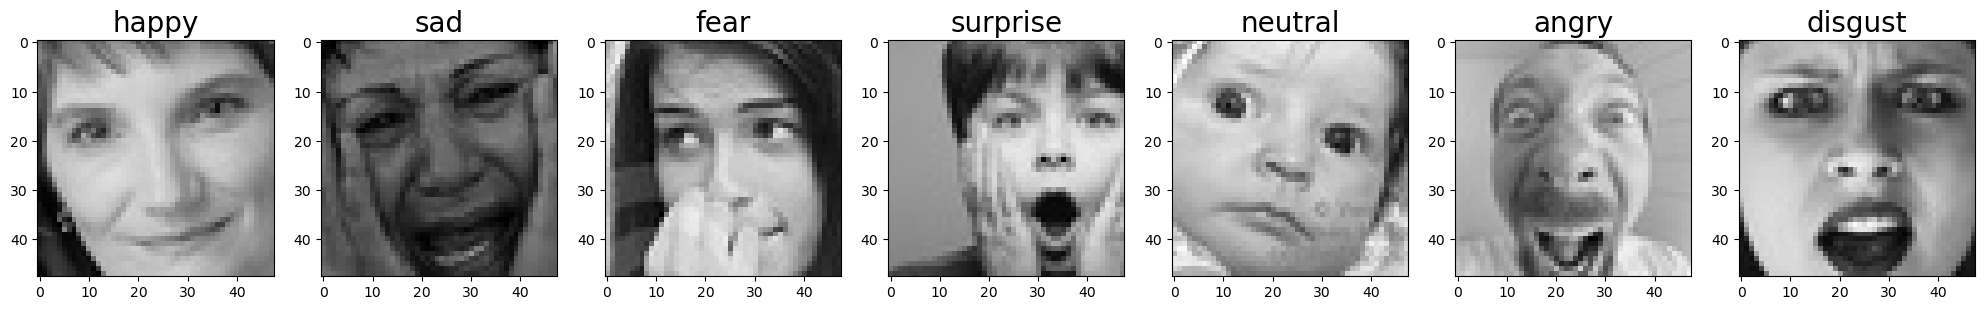

In [49]:
# Show sample images
import matplotlib.pyplot as plt
import cv2

plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL = './train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL +'/'+ directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

In [50]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


image_generator = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

training_data = image_generator.flow_from_directory(train_dir,
                                             target_size=(48,48),
                                             batch_size=32,
                                             color_mode = "grayscale",
                                             class_mode = "categorical")

test_data = image_generator.flow_from_directory(test_dir,
                                          target_size=(48,48),
                                          batch_size=32,
                                          color_mode='grayscale',
                                          class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# CNN Model

In [51]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(filters = 32, kernel_size=(3,3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(filters = 256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
# Convolutional Layer 2
model.add(Conv2D(filters = 128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
# Convolutional Layer 3
model.add(Conv2D(filters = 128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
# Convolutional Layer 4
model.add(Conv2D(filters = 64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
# Flattening
model.add(Flatten())
## Full connection layer
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
# Output Layer
model.add(Dense(7, activation='softmax'))

model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 conv2d_16 (Conv2D)          (None, 44, 44, 256)       73984     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 22, 22, 256)      0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 22, 22, 256)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 20, 20, 128)       295040    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 10, 10, 128)      0         
 g2D)                                                 

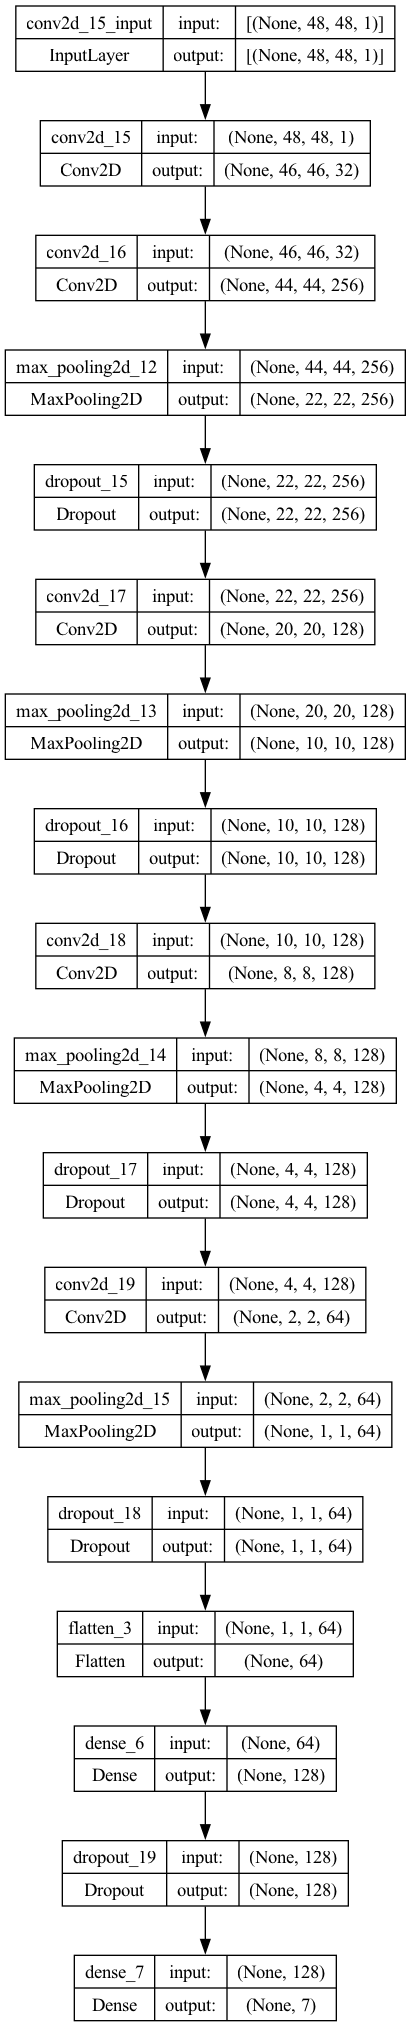

In [52]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [53]:
## Training the model
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
history = model.fit(training_data,
                    epochs=50,
                    batch_size=32,
                    validation_data = test_data,
                    shuffle=True,
                    callbacks = [early_stop]
                   )

Epoch 1/50


2023-11-29 17:46:48.492513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


898/898 [==============================] - ETA: 0s - loss: 1.8256 - accuracy: 0.2452

2023-11-29 17:49:56.470753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


898/898 [==============================] - 202s 224ms/step - loss: 1.8256 - accuracy: 0.2452 - val_loss: 1.7978 - val_accuracy: 0.2575
Epoch 2/50
898/898 [==============================] - 198s 221ms/step - loss: 1.7670 - accuracy: 0.2718 - val_loss: 1.6934 - val_accuracy: 0.2995
Epoch 3/50
898/898 [==============================] - 200s 223ms/step - loss: 1.6812 - accuracy: 0.3185 - val_loss: 1.5768 - val_accuracy: 0.3791
Epoch 4/50
898/898 [==============================] - 200s 223ms/step - loss: 1.5839 - accuracy: 0.3746 - val_loss: 1.4774 - val_accuracy: 0.4231
Epoch 5/50
898/898 [==============================] - 197s 220ms/step - loss: 1.5031 - accuracy: 0.4116 - val_loss: 1.3940 - val_accuracy: 0.4537
Epoch 6/50
898/898 [==============================] - 196s 218ms/step - loss: 1.4615 - accuracy: 0.4324 - val_loss: 1.3552 - val_accuracy: 0.4862
Epoch 7/50
898/898 [==============================] - 197s 220ms/step - loss: 1.4270 - accuracy: 0.4496 - val_loss: 1.3210 - val_accura

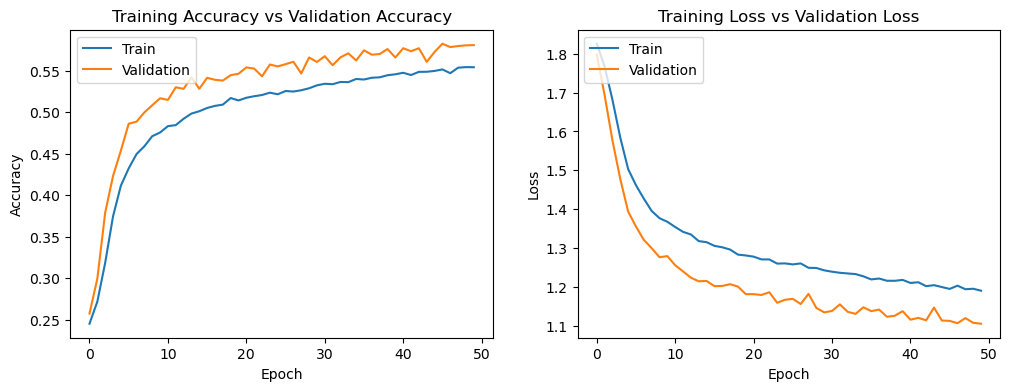

In [54]:
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12, 4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')
 
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')
 
plt.show()

In [56]:
loss, accu = model.evaluate(test_data)

print("Loss on test set: ", loss)
print("Accuracy on test set: ", accu)

  3/225 [..............................] - ETA: 12s - loss: 1.1873 - accuracy: 0.5833

2023-11-29 21:55:49.274898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


225/225 [==============================] - 13s 57ms/step - loss: 1.1011 - accuracy: 0.5791
Loss on test set:  1.101120948791504
Accuracy on test set:  0.5791306495666504


In [57]:
model.save('fer_2013.h5')
model.save_weights('fer_2013_weights.h5')

  3/225 [..............................] - ETA: 11s

2023-11-29 21:56:10.791266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


225/225 [==============================] - 13s 57ms/step


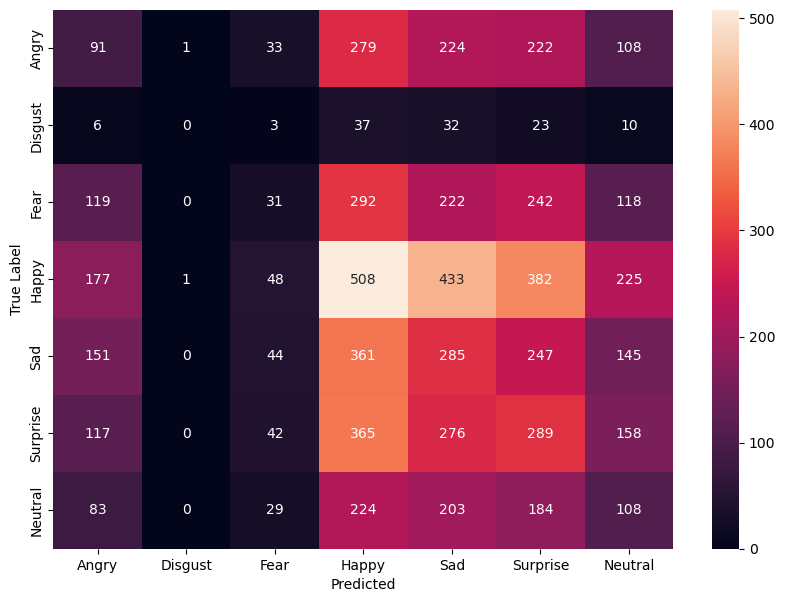

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
test_labels = test_data.classes
predictions = model.predict(test_data)
predicted_labels = predictions.argmax(axis=1)
cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()